# Reinforcement Learning Introduction

[Back to thinking wires blog post](https://thinkingwires.com/posts/2017-08-08-reinforcement-learning-intro.html)


## Requirements

You can run this jupyter notebook yourself after downloading it [here](https://thinkingwires.com/posts/2017-08-08-reinforcement-learning-intro.html).

Make sure you have the following packages installed:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Definition

The field of machine learning is typically classified into three categories - **supervised** learning, **unsupervised** learning, and **reinforcement** learning. The distinguishing property of reinforcement learning is the *interaction* of the learning system (often called agent) with some dynamic environment through actions. The agent receives rewards and punishments based on its performance and tries to *learn* the dynamics of the world and when to choose which action in order to maximize the expected reward. In most scenarios, the agent assigns a higher value to immediate rewards and discounts the importance of rewards that lie far in the future.

For this notebook we define some artificial grid world of size $8 \times 6$ with $48$ different states (fields of the grid world). The agent can move around in the world by chosing between the actions *left*, *up*, *right*, and *down*. Each step is punished by a reward of $-1$, except for steps leading to the *terminal state* which yield a reward of $+10$. In addition to the chosen action, the transition between states is influenced by *wind of different strengths*, blowing from south to north. Whenever the agent enters a field, it will instantly be pushed towards the top of the grid, depending on the strength of the wind at this field. 

For example, in the world below, let's assume there is a wind of strenght $2$ blowing in the second column of the world ($x=1$). If the agent is currently in state $[0,3]$ (blue dot) and performs the action *right* (blue arrow), the wind will instantly move it two fields up (red arrow). The combined outcome of action and environment dynamics is the state $[1,1]$. This step is punished by a reward of $-1$. Only when the agent reaches the terminal state (green dot), it can obtain a positive reward.

![(Image of grid world)](https://thinkingwires.com/projects/img/windyMDP-wind.png)


As it is typical in reinforcement learning, we define the world as a [Markov Decision Process (MDP)](https://en.wikipedia.org/wiki/Markov_decision_process).

MDPs contain the following components:

- A set of states $S$, in our case $S = \{[0,0], [0,1], \ldots , [7,5] \}$


- A set of actions $A$, in our case $A = \{left,up,right,down\}$


- The transition probabilities between states, for different actions $P$. For example we define the transition of moving right from the field $[0,0]$ to the field $[0,1]$ as follows: $P(right, [0,0], [0,1])=1$


- The rewards $R$ of being in state $s\in S$ and performing action $a\in A$. For example $R([0,0],right) = -1$


- A discount factor $\gamma \in [0,1]$ that defines how much we value future reward compared to reward of the current step. For example, $\gamma = 0.9$ means that expected future reward is worth $90\%$ of any current reward.

Now that we know all the 'ingredients' of a MDP ($MDP = \{S, A, P, R, \gamma \}$), in the next code block we define a function that can generate windy grid worlds of different sizes as MDPs.

**Side note**: it is enough to understand how the windy grid world functions, you don't need to look at the code below in detail.

In [260]:
def getWindyMDP(sizeX, sizeY, sTerminal, wind, gamma=0.9):
    """
    creates an MDP with specified size, terminal states and wind.
    sizeX : size of the grid along x axis, e.g. 6
    sizeY : size of the grid along y axis, e.g. 8
    sTerminal : list of terminal states, e.g. [[3,5], [2,4]]
    wind : list of wind strengths, e.g. [0, 0, 1, 1, 2, 2, 0, 0]
    important: len(wind) must equal sizeX
    """
    
    # set of states S:
    S = []
    for x in range(0, sizeX):
        for y in range(0, sizeY):
            S.append([x, y])
    
    # set of actions A:
    # [left, up, right, down]
    A = [[-1, 0], [0, -1],[1, 0], [0, 1]]
    
    # state transition probabilities P:
    # P[action, fromState, toState]
    P = np.zeros((len(A), len(S), len(S)))
    # loop over all state action pairs:
    for a, action in enumerate(A):
        for s, state in enumerate(S):
            nextX = state[0] + action[0]
            nextY = state[1] + action[1]
            # stop agent from moving off the grid along x axis:
            nextX = np.clip(nextX, 0, sizeX - 1)
            # apply wind:
            nextY -= wind[nextX]
            # stop agent from moving off the grid along y axis:
            nextY = np.clip(nextY, 0, sizeY - 1)
            # find index of s':
            sPrime = S.index([nextX, nextY])
            # set transition probabiliy:
            P[a, s, sPrime] = 1
    # terminal states cannot be left:
    for ts in sTerminal:
        tsIndex = ts[0] * sizeY + ts[1]
        P[:, tsIndex, :] = 0.0
        P[:, tsIndex, tsIndex] = 1.0        
            
    # rewards R:
    # R[state, action]
    R = np.ones((len(S), len(A)))
    # all state action pairs are -1 by default:
    R *= -1.0
    # reward state action pairs that lead to terminal states:
    for ts in sTerminal:
        x = ts[0]
        y = ts[1]
        tsIndex = x * sizeY + y
        rewardedActions = np.where(P[:, :, tsIndex] > 0)
        for i, action in enumerate(rewardedActions[0]):
            R[rewardedActions[1][i], action] = 10
        # there is zero reward for any action performed from a terminal state:
        R[tsIndex, :] = 0.0
          
    # return result:        
    mdp = {}
    mdp['S'] = S
    mdp['A'] = A
    mdp['P'] = P
    mdp['R'] = R
    mdp['sizeX'] = sizeX
    mdp['sizeY'] = sizeY
    mdp['sTerminal'] = sTerminal
    mdp['wind'] = wind
    mdp['gamma'] = gamma
    return mdp

In addition, let's define a function that can plot the grid world (this will make the results more easy to interpret later).

**Side note**: again, understanding the following `drawMDP` function is not required for following sections.

In [267]:
def drawMDP(mdp, v=None, title=None, policy=None, path=None):
    """
    Provides a plot of some MDP.
    Terminal states are plotted as green dots.
    If provided, the state values are plotted as heat map.
    If provided, the policy is plotted with arrows.
    If provided, some path is plotted as line.
    """
    
    # set axis and grid:
    plt.xlim(-1,mdp['sizeX'])
    plt.ylim(-1,mdp['sizeY'])
    plt.xticks(np.arange(0, mdp['sizeX'], 1))
    plt.yticks(np.arange(0, mdp['sizeY'], 1))
    plt.gca().invert_yaxis()
    
    # plot terminal states:
    for ts in mdp['sTerminal']:
        plt.scatter(ts[0], ts[1], c='lightgreen', edgecolor='b', s=200)
    
    # plot state values:
    if v is not None:
        # vMap = np.swapaxes(np.reshape(v, (mdp['sizeY'], mdp['sizeX'])), 0, 1)
        vMap = np.reshape(v, (mdp['sizeY'], mdp['sizeX']), order='F')
        plt.imshow(vMap, cmap='RdYlGn', interpolation='nearest', origin='upper')
        plt.colorbar()
        if policy is None:
            plt.grid()
        
    # add title:
    if title is not None:
        plt.title(title)
        
    # add policy arrows:
    if policy is not None:
        arrowLength = 0.01
        headLength = 0.25
        headWidth = 0.35
        for i in range(0, policy.shape[0]):
            x = mdp['S'][i][0]
            y = mdp['S'][i][1]
            if [x, y] in mdp['sTerminal']:
                continue
            dLeft = policy[i][0] * headWidth
            dUp = policy[i][1] * headWidth
            dRight = policy[i][2] * headWidth
            dDown = policy[i][3] * headWidth
            color = 'white'
            if v is None:
                color = 'black'
            if dLeft > 0:
                plt.arrow(x, y, -0.01, 0, head_width=dLeft, head_length=headLength, fc=color, ec=color)
            if dUp > 0:
                plt.arrow(x, y, 0, -0.01, head_width=dUp, head_length=headLength, fc=color, ec=color)
            if dRight > 0:
                plt.arrow(x, y, 0.01, 0, head_width=dRight, head_length=headLength, fc=color, ec=color)
            if dDown > 0:
                plt.arrow(x, y, 0, 0.01, head_width=dDown, head_length=headLength, fc=color, ec=color)
    
    # show path:
    if path is not None:
        path = np.array(path)
        x, y = path.T
        color = 'white'
        if v is None:
            color='black'
        plt.plot(x, y, color=color, linewidth=4)
    
    # show the plot:
    plt.show()

We define a new grid world of size $8 \times 6$ with wind blowing in the strengths $[0,0,1,1,2,2,0,0]$ - there is no wind in the first two columns from left to right, wind of strength 1 for $x=2$ and $x=3$, and so on. The only terminal state is $[5,3]$.

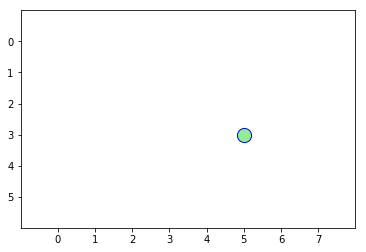

Wind: [0, 0, 1, 1, 2, 2, 0, 0]
Terminal states: [[5, 3]]
(array([46]),)


In [244]:
wind = [0, 0, 1, 1, 2, 2, 0, 0]
mdp = getWindyMDP(8, 6, [[5, 3]], wind)
drawMDP(mdp)
print('Wind: ' + str(mdp['wind']))
print('Terminal states: ' + str(mdp['sTerminal']))

## Our first policy

Reinforcement learning agents use a *policy* to choose actions. In any given state, the agent needs to decide which action it will perform next. A policy simply defines the probability of performing some action, given a certain state:

$\pi(a|s) = \mathbb{P}[A_t = a | S_t = s]$

For example, when our agent is at field $[0,5]$, it might always want to move *right*. In this case, the policy for this field would be defined as 

$\pi(right|[0,5]) = 1$

Since the probability of all possible actions at each state must sum up to $1$, in this case 

$\pi(up|[0,5]) = \pi(down|[0,5]) = \pi(left|[0,5]) = 0$

A good policy assigns high probabilities to actions that lead to high expected reward. 

In the beginning however, our agent is rather stupid and follows a **uniform random policy**. This means that for all states, the probability of any of the four possible actions is the same: $25\%$ for each action.

$\forall s \forall a: \pi(a|s) = \frac{1}{|A|}= 0.25$ 

No matter in which state the agent is, it will choose one direction at random and walk there. 

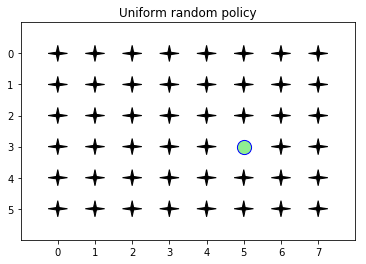

In [4]:
def getUniformPolicy(mdp):
    """
    Returns a very simple uniform random policy
    Action probabilities for some state index s: policy[s,:]
    """
    policy = np.ones((len(mdp['S']), len(mdp['A']))) * (1.0 / len(mdp['A']))
    return policy

uniformPolicy = getUniformPolicy(mdp)
drawMDP(mdp, title='Uniform random policy', policy=uniformPolicy)

The plot above shows the uniform random policy as black arrow-heads. Here we can see visually that the probability for each of the four directions is the same in all states. In this case there is no policy defined for the state $[5,3]$ since it is a terminal state that ends each episode. 

If we want to look at the policy for a certain state, we can access this information with the following line: 

In [22]:
statePolicy = uniformPolicy[0, :]
print("Uniform random policy for first state ([0,0]):")
print(statePolicy)

Uniform random policy for first state ([0,0]):
[ 0.25  0.25  0.25  0.25]


We can change the agent's policy by updating values of some state. 

For example, if we want the agent to always move right at $[0,0]$, we can change the policy as follows:

[ 0.  0.  1.  0.]


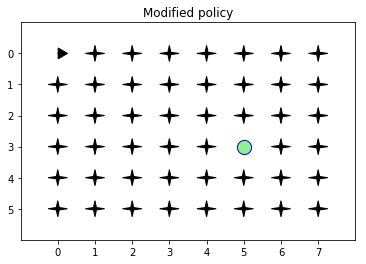

In [26]:
newPolicy = np.copy(uniformPolicy)
newPolicy[0, :] = [0, 0, 1, 0]
print(newPolicy[0, :])
drawMDP(mdp, title='Modified policy', policy=newPolicy)

## Value evaluation

In order to improve its policy, the agent needs to learn the value of all states. 

First of all let's think about what the value of a state $s$ might be. Since the agent cannot change whatever happened in the past, it is only interested in expected future reward. The value of a state consists of the sum of:

- The immediate reward $R^a_s$ of performing an action, weighted by the probability of performing this action (according to the agent's policy $\pi$, see previous section)

- The value $v_\pi(s')$ of the successor state $s'$, weighted by the probability of landing in this state (according to the state transition matrix $P$). Since in most cases the agent is inclined to choose high current rewards over high future rewards, we discount the value of the succesor state by multiplying with $\gamma$, e.g. $\gamma = 0.9$.

We introduce the state value function $v_\pi (s)$ with the so called Bellman expectation equation. This equation might look a bit intimidating at first glance, but is actually not that complex:

$ v_\pi(s) = \sum_{a\in A}\pi(a|s)(R^a_s + \gamma \sum_{s' \in S}P^a_{s,s'}v_\pi(s'))$

This equation is actually quite intutive. Let's look at the different components. For some given state $s$ we consider all the possible actions we can take and calculate the sum of the value of performing these actions, weighted by their probability according to the policy $\pi$.

The value of performing an action $a$ in state $s$ is the sum of the imediate reward $R^a_s$ plus the value of the state we end up in after performing the action. Since the transitions between states are stochastic, we weight this future value by the state transition probabilities $P^a_{s,s'}$ and discount the entire future reward by multiplying with $\gamma$.

We can see that the value function recursively depends on itself. There is a closed form solution of calculating $v$. In order to apply it, we first have to marginalize out the actions from the state transition probabilities $P$ and rewards $R$ over our policy as follows:

$P^\pi_{s,s'} = \sum_{a\in A}\pi(a|s)P^a_{s,s'}$

$R^\pi_{s} = \sum_{a\in A}\pi(a|s)R^a_s$

We can obtain the state values $v$ now by solving the following equation:

$v = (1 - \gamma P^\pi_{s,s'})^{-1}R^\pi_{s} $

The following function calculates this analytic solution to the state values for our uniform random policy.

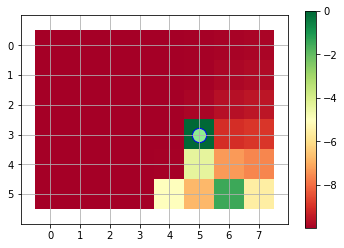

Wind: [0, 0, 1, 1, 2, 2, 0, 0]


In [5]:
def getAnalyticValuesEvaluation(mdp, policy):
    """
    Calculates the closed form exact solution 
    of the state values v of a given mdp and policy
    """
    P = mdp['P']
    R = mdp['R']
    Ppolicy = np.zeros(P.shape[1:])
    for a in range(0, len(mdp['A'])):
        Ppolicy += P[a] * policy[:, a]
    Rpolicy = np.zeros((len(mdp['S'])))
    for a in range(0, len(mdp['A'])):
        Rpolicy += R[:, a] * policy[:, a]
    v = np.linalg.inv(np.identity(len(mdp['S'])) - mdp['gamma'] * Ppolicy).dot(Rpolicy)
    return v

v = getAnalyticValuesEvaluation(mdp, uniformPolicy)
drawMDP(mdp, v)
print('Wind: ' + str(mdp['wind']))

The plot above shows the values of all states in the grid world (red states are bad, green states good). Note that these values depend on the previously defined *uniform random policy*. With a different policy, the values might look very different. We will see that later.

As we can see, the states with high value lie in the bottom right corner of the grid. When looking at the wind vector, we see that the last two columns don't have any wind. This means that those states have the highest probability of leading to the rewarded terminal state at $[5,3]$. The states to the left of $[5,3]$ are influenced to heavily by the strong wind - e.g. when going right from $[4,3]$ the wind blows the agent too far up and it ends up in $[4,1]$ instead. In states that lie left of the terminal state, the wind will blow the agent up too much and they will need many more random steps to finally reach the terminal state.

### Iterative value evaluation

The computational complexity of computing the state values analytically is $O(|S|^3)$ due to the matrix inversion. This is only possible for very small MDP (such as ours). For bigger ones, there are iterative methods that converge to the correct solution and are more efficient.

For example, we can use dynamic programming (DP) to iteratively update our estimate of the value function until converging to the correct values

To get the estimate $v_k(s)$ in iteration $k$, we use the value estimates for successor states $s'$ of the previous iteration $v_{k-1}(s)$ in the Bellmann expectatin equation:

$ v_k(s) = R^\pi_{s} + \gamma \sum_{s' \in S}P^\pi_{s,s'}v_{k-1}(s'))$

We can initialize $v_0$ with any value and this process will always converge to the true value function. 

This is implemented in the following function:

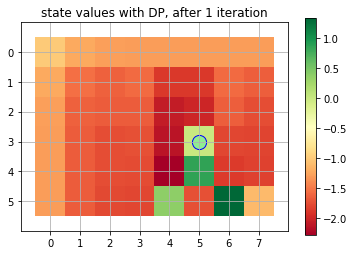

MSE: 61.0304667605




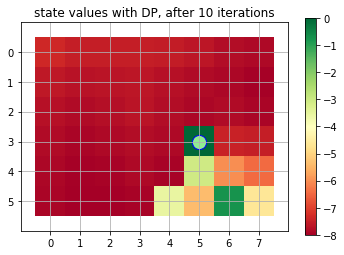

MSE: 4.04788123499




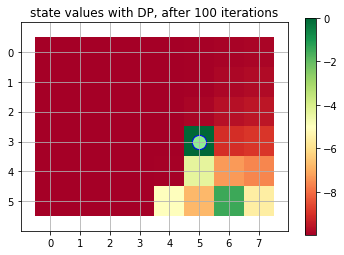

MSE: 1.05719795525e-11




In [146]:
def getDPValuesEvaluation(mdp, policy, iterations=100, vHistory=False, initialV=None):
    """
    Iterative approach of state value estimation using dynamic programming
    Setting vHistory=True will also return all intermediate estimates v_k
    """
    
    # if no initial values for v are provided, initialize with zeros:
    if initialV is None:
        v = np.zeros(len(mdp['S']))
    else:
        v = initialV
    
    P = mdp['P']
    R = mdp['R']
    
    # marginalize out actions from P and R:
    Ppolicy = np.zeros(P.shape[1:])
    for a in range(0, len(mdp['A'])):
        Ppolicy += P[a] * policy[:, a]
    
    Rpolicy = np.zeros((len(mdp['S'])))
    for a in range(0, len(mdp['A'])):
        Rpolicy += R[:,a] * policy[:, a]
    
    if vHistory is not False:
        vHistory = []
        
    for i in range(0, iterations):  
        for j in range(0, len(v)):
            v[j] = Rpolicy[j] + mdp['gamma'] * np.sum(Ppolicy[j, :] * v)
        
        if vHistory is not False:
            vHistory.append(list(v))
        
    if vHistory is not False:
        return v, vHistory
    return v

# obtain exact solution to calculate DP errors
vExact = getAnalyticValuesEvaluation(mdp, uniformPolicy)

# 1 iteration:
v = getDPValuesEvaluation(mdp, uniformPolicy, 1)
drawMDP(mdp, v, 'state values with DP, after 1 iteration')
print('MSE: ' + str(np.mean((v - vExact) ** 2)) + '\n\n')

# 10 iterations:
v = getDPValuesEvaluation(mdp, uniformPolicy, 10)
drawMDP(mdp, v, 'state values with DP, after 10 iterations')
print('MSE: ' + str(np.mean((v - vExact) ** 2)) + '\n\n')

# 100 iterations:
v = getDPValuesEvaluation(mdp, uniformPolicy, 100)
drawMDP(mdp, v, 'state values with DP, after 100 iterations')
print('MSE: ' + str(np.mean((v - vExact) ** 2)) + '\n\n')

The three plots above show the dynamic programming value estimates after 1, 10, and 100 iterations. After 100 iterations, the value estimates have converged to almost the exact same values as with our exact solution from before.

In the two plots below, you can see the mean squared error (MSE) between the exact value function and the DP estimates. The error decreases quite drastically in the beginning and then much slower.

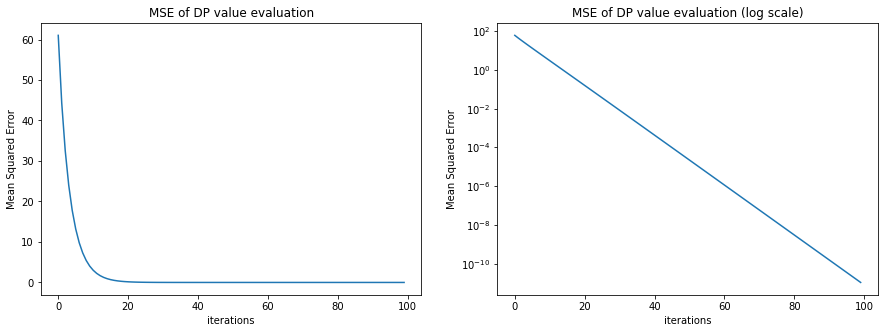

In [7]:
# plot MSE graphs over 100 iterations
v, vHistory = getDPValuesEvaluation(mdp, uniformPolicy, 100, True)
vExact = getAnalyticValuesEvaluation(mdp, uniformPolicy)
MSEs = []
for vIt in vHistory:
    MSEs.append(np.mean((vIt - vExact) ** 2))

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(range(0,len(vHistory)), MSEs)
plt.title('MSE of DP value evaluation')
plt.xlabel('iterations')
plt.ylabel('Mean Squared Error')
plt.subplot(1,2,2)
plt.semilogy(range(0,len(vHistory)), MSEs)
plt.title('MSE of DP value evaluation (log scale)')
plt.xlabel('iterations')
plt.ylabel('Mean Squared Error')
plt.show()


The MSE converges to $0$, meaning that the DP estimates converge towards the exact solution.

## Policy Iteration

Now that the agent can evaluate the value of different states either exactly or iteratively, let's have it improve its own policy. Right now the agent follows a rather unintelligent uniform random policy, with $0.25$ probability of performing any action in all states:


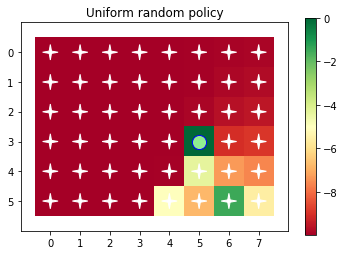

In [8]:
policy = getUniformPolicy(mdp)
v = getAnalyticValuesEvaluation(mdp, policy)
drawMDP(mdp, v, 'Uniform random policy', policy)

How do we improve this policy? 


Intuitively it is clear, that the agent should try to move to states with high value. 

For example, when the agent is currently in $[7,5]$ (see above), it is most desirable to move *left*, since $[6,5]$ has the highest value of all possible successor states. Instead of moving randomly in any direction, the agent should always move left in this case.

So based on the current state value estimates, the agent can greedily pick those actions that lead to states with the highest value (since those values entail expected future rewards, not only immediate rewards). So for each state, we greedily pick the action that leads to the highest value: 

$\pi' = greedy(v_\pi) = argmax_{a\in A} R^a_s + \gamma \sum_{s' \in S}P^a_{s, s'} v_\pi(s')$

After changing its policy in this *greedy* manner, the agent needs to update the state values based on this new policy. 

These two steps of updating the value function and greedily improving the policy can be repeated iteratively. This is called **policy iteration**. This process converges to the optimal policy $\pi_*$ and we can terminate the process once the policy does not change between two consecutive iterations.

(There are other methods such as value iteration which I didn't cover here. The core idea is similar though, it just uses the Bellman optimality equation instead of the Bellmann expectation equation).

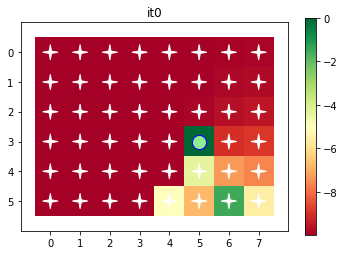

[2 2 2]


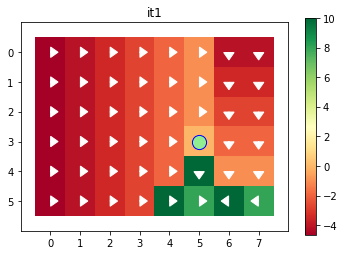

[1 1 1]


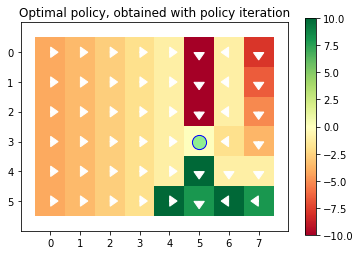

In [147]:
def policyIteration(mdp):
    
    policy = getUniformPolicy(mdp)
    
    v = getDPValuesEvaluation(mdp, policy, iterations=1)
        
    
    # Repeat until policy does not change between two iterations
    counter = 0
    while True:
        #v = getDPValuesEvaluation(mdp, policy, iterations=1000, initialV=v)
        v = getAnalyticValuesEvaluation(mdp, policy)
        drawMDP(mdp, v, 'it' + str(counter), policy)
        print(np.argmax(np.sum(mdp['P'] * v, axis=2), axis=0)[30:33])
        oldPolicy = np.copy(policy)
        policy = np.zeros((policy.shape))
        # choose optimal actions for new policy:
        bestActions = np.argmax(mdp['R'].T + mdp['gamma'] * np.sum(mdp['P'] * v, axis = 2), axis=0)
        policy[np.arange(0, len(mdp['S'])), bestActions] = 1
        
       
        
        counter += 1
        if counter == 2:
            break
        
        # stop criterion: 
        if (policy == oldPolicy).all():
            break
        
    return policy

policy = policyIteration(mdp)
v = getAnalyticValuesEvaluation(mdp, policy)
drawMDP(mdp, v, 'Optimal policy, obtained with policy iteration', policy)

In [143]:
mdp['P'] = np.array([[[0.5,0.5,0],[0,1,0],[0,0,1]],[[0,1,0],[0,0,1],[1,0,0]]])
print(mdp['P'])
v = [13, 5, 2]
print()
print(v)
print()
print(mdp['P'] * v)
print()
print(np.sum((mdp['P'] * v), axis = 2))
print()
print(np.argmax(np.sum((mdp['P'] * v), axis = 2), axis = 0))

mdp['R'] = np.array([[1, 2], [3, 4], [55, 2]])
print()
print(mdp['R'].T)
print()
print(mdp['R'].T + 0.3 * np.sum((mdp['P'] * v), axis = 2))
print()
bestActions = np.argmax(mdp['R'].T + 0.3 * np.sum((mdp['P'] * v), axis = 2), axis = 0)
print(bestActions)
print()
policy = np.zeros((3,2))
print(policy)
policy[np.arange(0, 3), bestActions] = 1
print(policy)

[[[ 0.5  0.5  0. ]
  [ 0.   1.   0. ]
  [ 0.   0.   1. ]]

 [[ 0.   1.   0. ]
  [ 0.   0.   1. ]
  [ 1.   0.   0. ]]]

[13, 5, 2]

[[[  6.5   2.5   0. ]
  [  0.    5.    0. ]
  [  0.    0.    2. ]]

 [[  0.    5.    0. ]
  [  0.    0.    2. ]
  [ 13.    0.    0. ]]]

[[  9.   5.   2.]
 [  5.   2.  13.]]

[0 0 1]

[[ 1  3 55]
 [ 2  4  2]]

[[  3.7   4.5  55.6]
 [  3.5   4.6   5.9]]

[0 1 0]

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]


The plot above shows the optimal policy, obtained with policy iteration.

Each arrow shows in which direction the agent moves according to the policy in a given state. Note that the optimal policy is deterministic - there is always exactly one optimal action per state. 

To get a feeling of the difference between the uniform and optimal policy, let's plot the path of the agent, first following a uniform random policy and then following the optimal one:

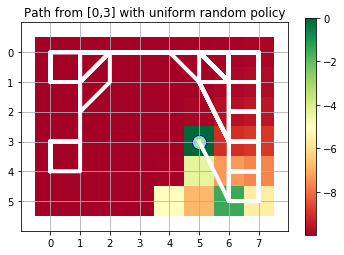

Wind: [0, 0, 1, 1, 2, 2, 0, 0]
Path length: 375


In [10]:
def getPath(mdp, policy, startPoint, maxLength=None):
    """
    Returns a path between startPoint and the first reached terminal state
    when following the specified policy
    Set maxLength to avoid endless loops in cases where no terminal state can be reached.
    """
    path = [startPoint]
    counter = 0
    while True:
        if maxLength and counter >= maxLength:
            break
        # follow policy to perform next action:
        s = path[-1]
        if s in mdp['sTerminal']:
            break
        sIndex = s[0] * mdp['sizeY'] + s[1]
        action = np.random.choice(4, p = policy[sIndex])
        sPrimeIndex = np.random.choice(len(mdp['S']), p = mdp['P'][action,sIndex,:])
        path.append(mdp['S'][sPrimeIndex])
        counter += 1
    return path

policy = getUniformPolicy(mdp)
v = getAnalyticValuesEvaluation(mdp, uniformPolicy)
startPoint = [0,3]
path = getPath(mdp, policy, startPoint)
drawMDP(mdp, v, title = 'Path from [0,3] with uniform random policy', path = path)
print('Wind: ' + str(mdp['wind']))
print('Path length: ' + str(len(path)-1))

Since the uniform random policy is stochastic, the path will look different each time when executing the codeblock above. One similarity however is, that the agent usually needs several hundred, if not thousand steps to reach the terminal state. 

Now let's look at the (deterministic) path following the optimal policy:

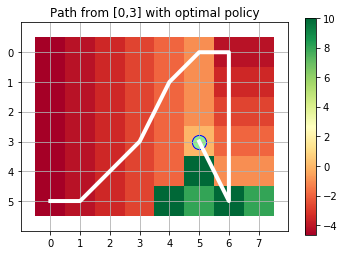

Wind: [0, 0, 1, 1, 2, 2, 0, 0]
Path length: 12


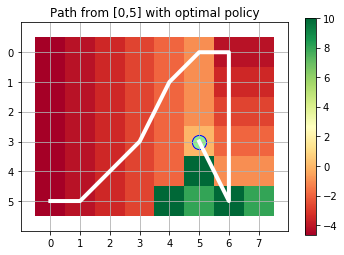

Wind: [0, 0, 1, 1, 2, 2, 0, 0]
Path length: 12


In [18]:
policy = policyIteration(mdp)
v = getAnalyticValuesEvaluation(mdp, policy)
path = getPath(mdp, policy, startPoint)
drawMDP(mdp, v, title = 'Path from [0,3] with optimal policy', path = path)
print('Wind: ' + str(mdp['wind']))
print('Path length: ' + str(len(path)-1))

startPoint = [0,5]
path = getPath(mdp, policy, startPoint)
drawMDP(mdp, v, title = 'Path from [0,5] with optimal policy', path = path)
print('Wind: ' + str(mdp['wind']))
print('Path length: ' + str(len(path)-1))

Clearly, this path is much shorter, leading to much less negative reward on the way to the terminal state. 

In addition, we can see why the state values of the left column is the same for all rows: On the way to the terminal state the agent is blown up by the wind, so no matter how far south it starts, it will be blown to the most northern row and can only walk down once it reaches the last two columns which are wind-free

## Model Free Prediction

So far we have assumed that the agent has full knowledge of the MDP - it knows all state transition probabilities $P$ and rewards $R$.

This is not realistic in many problems - the dynamics of the environment might be partially observed or even entirely unknown.

So now, let's look at some algorithms that can learn optimal policies even without having an explicit model of the world.

Just as before, we start with evaluating the value of states (prediction) and then move on towards improving the agent's policy (control).

Now, everything that is known to the agent is the set of possible states $S$ and possible actions $A$, as well as the discounting factor of future rewards $\gamma$:

In [12]:
def getModelFreeRepresentation(mdp):
    return mdp['S'], mdp['A'], mdp['gamma']

S, A, gamma = getModelFreeRepresentation(mdp)

### Sampling the MDP:

Since it is not provided with the state transition probabilities $P$ and rewards $R$ anymore, the agent has to collect data about the environment and learn from it. 

This is done by the agent moving around in the environment, following some policy (e.g. uniform random to start with) and storing all states, actions and rewards as experience. 

This process is called sampling. All information between some random starting state and a terminal state is called an *episode*. An episode is a sequence of states, actions and rewards:

$S_1, A_1, R_2, \ldots, S_k \sim \pi $

The following function returns a random episode from a given MDP:

In [13]:
def getSampledEpisode(mdp, policy, startIndex=None):
    """
    Samples an episode starting at some random state
    Without startIndex, the initial state is chosen 
    from uniform random distribution over all states
    """
    if startIndex is None:
        currentState = np.random.randint(0, len(mdp['S']))
    else:
        currentState = startIndex
    sampledStates = []
    sampledActions = []
    sampledRewards = []
    while True:
        sampledStates.append(currentState)
        if mdp['S'][currentState] in mdp['sTerminal']:
            break
        action = np.random.choice(len(mdp['A']), p=policy[currentState])
        sampledActions.append(action)
        sampledRewards.append(mdp['R'][currentState, action])
        currentState = np.argmax(mdp['P'][action, currentState, :])
        
    return sampledStates, sampledActions, sampledRewards

Let's sample one episode using the uniform random policy from before:

sampled episode of length 57
last ten states, actions & rewards:
[41, 47, 41, 47, 41, 41, 40, 41, 41, 33]
[0, 2, 0, 2, 0, 1, 3, 1, 1, 0]
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 10.0]
overall reward: -45.0


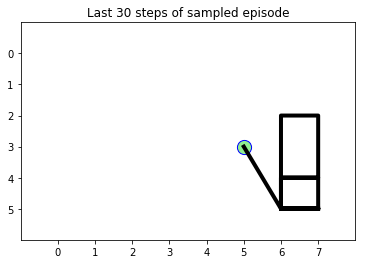

In [14]:
policy = getUniformPolicy(mdp)
episode = getSampledEpisode(mdp, policy)
print('sampled episode of length ' + str(len(episode[0])))
print('last ten states, actions & rewards:')
print(episode[0][-10:])
print(episode[1][-10:])
print(episode[2][-10:])
print('overall reward: ' + str(np.sum(episode[2])))
path = list(np.take(mdp['S'], episode[0][-30:], axis=0))
v = getAnalyticValuesEvaluation(mdp, policy)
drawMDP(mdp, title = 'Last 30 steps of sampled episode', path = path)

Since the used policy is stochastic, the path of the sampled episode will in most cases include detours and non-optimal sequences.

In most cases, the ouput above will show a big negative overall reward for the entire episode. Obviously this policy leads to far too long episodes in most cases.

### Monte Carlo Evaluation

Now that we can collect experience from the world, we can use this experience to estimate the value of different states.

The first method that we are going to look at is not known for being particulary efficient, but it is very effective and widely used in practice: **Monte Carlo Learning** 

You might be familiar with Monte Carlo methods from other domains. The basic idea here is that we approximate the value of some state $v_\pi(s)$ with the expected value $\mathbb{E}_\pi [G_t | S_t = s ] $ where the return $G_t$ is defined as the sum of all future rewards until the end of the episode, discounted with $\gamma$:

$G_t = R_{t+1} + \gamma  R_{t+2} + \gamma ^2  R_{t+3} + \ldots $

We are going to use ever-visit Monte Carlo learning, where each time a state is visited during an episode, we use the current $G_t$ to update the expected value.

In order to do this, we use two variables for each state: $N(s)$ counts how often we have visited state $s$ and $S(s)$ is the sum of all the different $G_t$ when visiting $s$.

To get $G_1, \ldots, G_k$ for some episode with $k$ states, we start with initializing $G_{k+1} = 0$ (after reaching the terminal state there is no future reward). Then we can simply move backwards, updating $G_t$ as:

$G_t := R_{t+1} + \gamma G_{t+1}$

Then, for each timestep $t$ we increment $N(S_t)$ by one and add $G_t$ to $S(S_t)$.

In the end, we obtain $V(s) = \frac{S(s)}{N(s)}$. For large $N(s)$, $V(s)$ converges to $v_\pi(s)$.

Instead of starting the episodes from random states, we start the first episode at [0,0], the second one at [0,1] and so on. This is just to make sure that all episodes are visitied at least once when sampling at least 48 episodes. This becomes statistically unneccessary when sampling sufficient episodes. 

Let's run this for 1000 episodes sampled from the uniform random policy. This takes quite a while, since most of the episode contain many useless random steps and are relatively long. If you want faster (but less accurate results, decrease the iterations parameter):

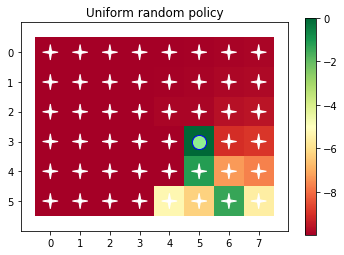

In [15]:
def policyEvalMC(S, A, gamma, mdp, iterations=1000, vHistory=False):
    """
    get value estimates with Monte Carlo learning
    """
    Ns = np.zeros(len(S))
    Ss = np.zeros(len(S))
    
    if vHistory is not False:
        vHistory = []
    
    for i in range(0, iterations):
        
        # start new episode from consecutive states:
        startIndex = i % len(S)
        
        # get sampled episode:
        # (this is the only time we use the mdp information!)
        sampS, sampA, sampR = getSampledEpisode(mdp, policy, startIndex)
        
        # add implicit reward of 0 after terminal state for convenience:
        sampR += [0]
        
        Gt = 0
        for j in range(1,len(sampS)+1):
            Gt = sampR[-j] + gamma * Gt
            s = sampS[-j]
            Ns[s] += 1
            Ss[s] += Gt
        
        if vHistory is not False:
            vs = np.copy(Ss)
            vs[np.where(Ns > 0)] /= Ns[np.where(Ns > 0)]
            vs[np.where(Ns == 0)] = float('nan')
            vHistory.append(list(vs))
        
    
    if vHistory is not False:
        return vs, vHistory
    return vs

policy = getUniformPolicy(mdp)
v, vHistory = policyEvalMC(S, A, gamma, mdp, vHistory=True)
drawMDP(mdp, v, 'Uniform random policy', policy)

As we can see above, after evaluating 1000 episodes with Monte Carlo learning, the agent obtains estimates of the state values that are very close to the exact solution.

However, there are several problems with this Monte Carlo learning technique:

- MC learning can only be applied to *episodic* MDPs where all episodes reach a terminal state and end at some point. We must always wait for the end of an episode to use it for learning - making this technique non-applicable for on-line learning (learning while the agent is still acting on the environment)


- Since the different $G_t$ depend on very many random actions and transitions, they exhibit very high variance. The MC learning results are unbiased, but we need to sample a lot of episodes to deal with the high variance.

Let's demonstrate the high variance of MC learning estimates in the following plot:

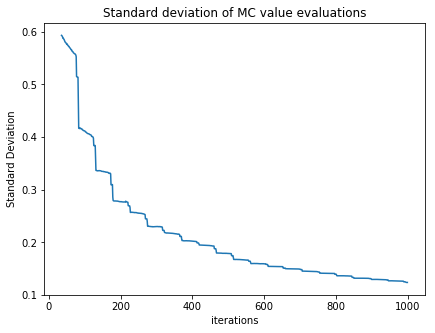

In [16]:
# getting the data for the following plot takes a long time.
# leave this block as it is, if you don't want to wait for long
# otherwise:
# comment out the next code block 
# and uncomment the code block after

from IPython.display import Image
Image("img/MCeval-std.png")

# vHistories = []
# for i in range(0, 100):
#     v, vHistory = policyEvalMC(S, A, gamma, mdp, vHistory=True)
#     vHistories.append(vHistory)
# vHistory = np.std(np.array(vHistories), axis=0)
# vExact = getAnalyticValuesEvaluation(mdp, uniformPolicy)
# meanStds = []
# for vIt in vHistory:
#     meanStds.append(np.mean(vIt))
# plt.plot(range(0,len(vHistory)), meanStds)
# plt.title('Standard deviation of MC value evaluations')
# plt.xlabel('iterations')
# plt.ylabel('Standard Deviation')
# plt.show()

The plot above shows how especially when only running for a small number of episodes (iterations), the obtained estimates of state values exhibit very high variance. We can decrease the variance by running the MC algorithm for more iterations, but of course this comes with higher computational costs.

When using MC learning to estimate the values of states, we always use the *entire* sequence of rewards following some state. This includes rewards that happen very long after a state has been visited and this is the main reason of why the unbiased state value estimates suffer from such high variance.

### TD(0) learning

Let's now look at temporal difference (TD) learning and start with the TD(0) algorithm where the TD-error is estimated based on one single reward following each state.

I will not go into the theoretical details of this algorithm here (if you're interested, check out the video lectures I mentioned before), but the crucial update rule for this algorithm is the following one:

$V(S_t) := V(S_{t}) + \alpha [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]$

Here we apply *bootstrapping* to estimate the state values. Instead of updating values based on *all* future rewards, we only look at the next reward and use our own current estimate of the successor state's value to approximate the rest. We use *bootstrapping* in order to avoid having to wait until all rewards until the end of the episode are clear.

$R_{t+1} + \gamma V(S_{t+1})$ is called **TD target** - it is based on some actual observed reward and the discounted estimate of the successor state's value. 

$ [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]$ is the **TD error** - simply how much our former estimate of $V(S_t)$ deviates from the new estimate. 

We then use the learning rate $\alpha$ to define how strongly we update $V(S_t)$ into the direction of the observed TD target.

We initialize the state value estimates with some arbitrary vector (e.g. all values equal zero) and then update them based on observed TD errors.

Have a look at the algorithm here:

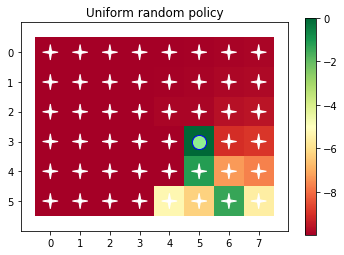

In [17]:
def policyEvalTDZero(S, A, gamma, mdp, alpha=0.01, iterations=100, vHistory=False):
    """
    get value estimates with Monte Carlo learning
    """
    vs = np.zeros(len(S))
    
    if vHistory is not False:
        vHistory = []
    
    for i in range(0, iterations):
        
        # start new episode from consecutive states:
        startIndex = i % len(S)
        
        # get sampled episode:
        # (this is the only time we use the mdp information!)
        sampS, sampA, sampR = getSampledEpisode(mdp, policy, startIndex)
        
        # add implicit reward of 0 after terminal state for convenience:
        sampR += [0]
        # add implicit repetition of terminal state in the end:
        sampS.append(sampS[-1])
        
        # update vs based on TD errors of episode
        for i in range(0, len(sampS)-1):
            tdTarget = sampR[i] + gamma * vs[sampS[i+1]]
            tdError = tdTarget - vs[sampS[i]]
            vs[sampS[i]] = vs[sampS[i]] + alpha * tdError
           
        if vHistory is not False:
            vHistory.append(list(vs))
        
    
    if vHistory is not False:
        return vs, vHistory
    return vs
        

vs = policyEvalTDZero(S, A, gamma, mdp)
drawMDP(mdp, v, 'Uniform random policy', policy)

### TD($\lambda$)

Now we've seen the two extreme cases of model-free value prediction: either looking at all future rewards or only looking at the very next one. 

There is a form of temporal difference learning where we can consider all future rewards but decay more distant rewards with a factor $\lambda$. Both MC learning and TD(0) can be considered special cases of this algorithm with MC learning having no decay at all ($\lambda = 1$) and TD(0) decaying everything after the first reward instantly ($\lambda = 0$).

Wind: [0, 0, 0, 0, 0, 0, 0, 0]
Terminal states: [[5, 3]]


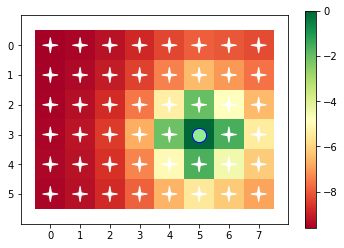

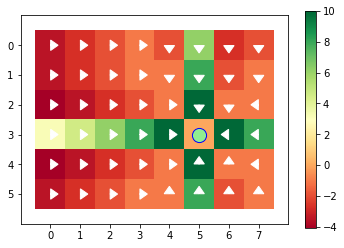

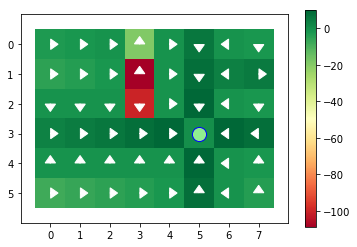

In [323]:
wind = [0, 0, 0, 0, 0, 0, 0, 0]
mdp = getWindyMDP(8, 6, [[5, 3]], wind)
print('Wind: ' + str(mdp['wind']))
print('Terminal states: ' + str(mdp['sTerminal']))

policy = getUniformPolicy(mdp)
v = getDPValuesEvaluation(mdp, policy, iterations=500)
drawMDP(mdp, v, policy=policy)


converged = False
counter = 0
while not converged and counter < 2:
    counter += 1
    oldPolicy = np.copy(policy)
    policy = np.zeros((policy.shape))
    # choose optimal actions for new policy:
    bestActions = np.argmax(mdp['R'].T + mdp['gamma'] * np.sum(mdp['P'] * v, axis = 2), axis=0)
    policy[np.arange(0, len(mdp['S'])), bestActions] = 1
    diff = np.sum(np.abs(oldPolicy - policy))
    # print(diff)
    if diff < 0.5:
        converged = True
    v = getAnalyticValuesEvaluation(mdp, policy)
#     v = getDPValuesEvaluation(mdp, policy, iterations=5)
    drawMDP(mdp, v, policy=policy)
    


In [331]:
tos = np.where(mdp['P'][:,19,:] > 0)[1]
for to in tos:
    print(S[to])
    


[2, 1]
[3, 0]
[4, 1]
[3, 2]


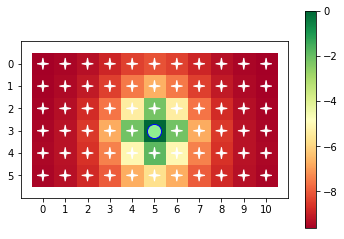

In [307]:

v = getAnalyticValuesEvaluation(mdp, policy)
drawMDP(mdp, v, policy=policy)

In [329]:
policy = np.array([[ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  0.,  1.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  0.,  1.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  0.,  1.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  0.,  0.,  1.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  0.,  1.,],  [ 0.,  0.,  0.,  1.,],  [ 0.,  0.,  0.,  1.,],  [ 1.,  0.,  0.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 1.,  0.,  0.,  0.,],  [ 1.,  0.,  0.,  0.,],  [ 1.,  0.,  0.,  0.,],  [ 1.,  0.,  0.,  0.,],  [ 1.,  0.,  0.,  0.,],  [ 1.,  0.,  0.,  0.,],  [ 0.,  0.,  0.,  1.,],  [ 0.,  0.,  1.,  0.,],  [ 0.,  0.,  0.,  1.,],  [ 1.,  0.,  0.,  0.,],  [ 0.,  1.,  0.,  0.,],  [ 0.,  1.,  0.,  0.,]])

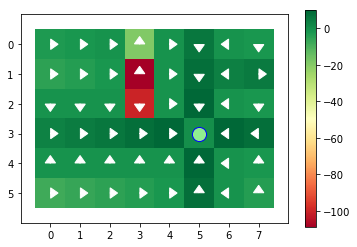

In [330]:
v = getAnalyticValuesEvaluation(mdp, policy)
drawMDP(mdp, v, policy=policy)

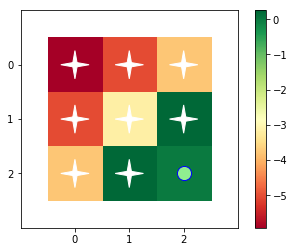

13.5


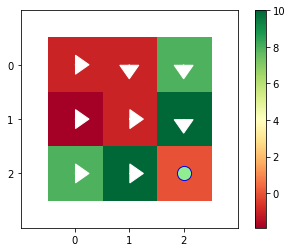

6.0


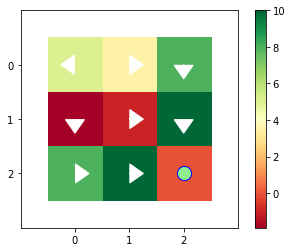

0.0


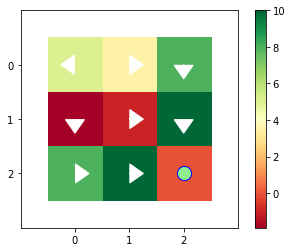

In [337]:
wind = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mdp = mdp = getWindyMDP(3, 3, [[2, 2]], wind)
policy = getUniformPolicy(mdp)
v = getAnalyticValuesEvaluation(mdp, policy)
drawMDP(mdp, v, policy=policy)

converged = False
counter = 0
while not converged and counter < 4:
    counter += 1
    oldPolicy = np.copy(policy)
    policy = np.zeros((policy.shape))
    # choose optimal actions for new policy:
    bestActions = np.argmax(mdp['R'].T + mdp['gamma'] * np.sum(mdp['P'] * v, axis = 2), axis=0)
    policy[np.arange(0, len(mdp['S'])), bestActions] = 1
    diff = np.sum(np.abs(oldPolicy - policy))
    print(diff)
    if diff < 0.5:
        converged = True
    v = getAnalyticValuesEvaluation(mdp, policy)
#     v = getDPValuesEvaluation(mdp, policy, iterations=5)
    drawMDP(mdp, v, policy=policy)